In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import time  # To track the elapsed time
import matplotlib.colors as mcolors
import concurrent.futures
import re
!pip install fuzzywuzzy
from fuzzywuzzy import process 
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

/srv/conda/envs/notebook/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Variable to Plot

In [2]:
var = 'default'
name = '_MSWEP_1D'
aggregate= 'mean'
save = True
percentile_filter = False

if var == 'default':
    var = 'returnPeriod_MSWEP_1d'
    name = ''
    folder = ''
    aggregate= 'mean'
    percentile_filter = False
else:
    folder = 'SI/'

perc_filter = 'no_percentile_filter'
if percentile_filter:
    perc_filter = 'percentile_filter'  

# Load Data

In [3]:
final_disasters_df = pd.read_csv(perc_filter+"/final_filtered_disasters.csv")
final_disasters_df['fullFIPS'] = final_disasters_df['fullFIPS'].astype(int).astype(str)
final_disasters_df['fullFIPS'] = final_disasters_df['fullFIPS'].apply(lambda x: str(x).zfill(5))

# Read the two CSV files
owners_df = pd.read_csv(perc_filter+"/final_filtered_aid_owners.csv")
renters_df = pd.read_csv(perc_filter+"/final_filtered_aid_renters.csv")

# Concatenate the dataframes
filtered_aid_df = pd.concat([owners_df, renters_df], ignore_index=True)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].astype(int).astype(str)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].apply(lambda x: str(x).zfill(5))
filtered_aid_df = filtered_aid_df.groupby(["disasterNumber","fullFIPS"]).agg({'approvedForFemaAssistance': 'sum' }).reset_index()

final_disasters_df = final_disasters_df.merge(filtered_aid_df[["disasterNumber","fullFIPS",'approvedForFemaAssistance']], how="left", on=["disasterNumber","fullFIPS"])

In [4]:
# Redefine the colors for the updated disaster types
disaster_colors = {
    'Hurricane/Tropical Cyclone': '#cce6e5',
    'Flood': '#66a2bf',
    'Storm': '#fdfbb5',
    'Dam/Levee Break': '#FEC98F'
}

# Ensure fullFIPS has leading zeros (5 characters)
final_disasters_df['fullFIPS'] = final_disasters_df['fullFIPS'].astype(int).astype(str).str.zfill(5)

# Calculate the order of incident types based on counts, largest to smallest
incident_order = final_disasters_df['incidentType'].value_counts().index.tolist()

# Set the color palette for the bar plot based on the updated disaster types
palette = [disaster_colors[dt] for dt in incident_order]

# 1. Map of mode disaster type by county (now the top panel)
# Aggregate mode disaster type by county
mode_disaster_df = final_disasters_df.groupby('fullFIPS')['incidentType'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()

# Load the state boundaries shapefile
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Load the county shapefile and merge with mode disaster data
county_shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)
gdf_counties = gdf_counties.merge(mode_disaster_df, left_on='GEOID', right_on='fullFIPS', how='left')

# Convert 'incidentType' in gdf_counties to a categorical type with the specified order
gdf_counties['incidentType'] = pd.Categorical(gdf_counties['incidentType'], categories=incident_order)

# Define a categorical color map based on updated disaster types
disaster_cmap = mcolors.ListedColormap([disaster_colors[dt] for dt in incident_order])
norm = mcolors.BoundaryNorm(range(len(disaster_colors) + 1), disaster_cmap.N)

In [5]:
# Filter data to include only rows where returnPeriod_ERA5_30d_max_sum is not NaN
valid_disasters_df = final_disasters_df.dropna(subset=[var])

# Replace NaNs with 0 and ensure all values are non-negative integers
valid_disasters_df['approvedForFemaAssistance'] = pd.to_numeric(
    valid_disasters_df['approvedForFemaAssistance'], errors='coerce'
).fillna(0).clip(lower=0).astype(int)

# Ensure the column is an integer (it should represent the number of repetitions)
valid_disasters_df = valid_disasters_df.loc[final_disasters_df.index.repeat(final_disasters_df['approvedForFemaAssistance'])]

# Reset the index (optional, for a cleaner index after repetition)
valid_disasters_df = valid_disasters_df.reset_index(drop=True)

# Filter data to include only the maximum returnPeriod_ERA5_30d_max_sum for each disasterNumber
if aggregate == 'max':
    return_period_df = valid_disasters_df.loc[valid_disasters_df.groupby('disasterNumber')[var].idxmax()]
elif aggregate == 'mean':
    return_period_df = (
    valid_disasters_df.groupby('disasterNumber', as_index=False)
        .agg(
            {
                var: 'mean',  # Compute the mean of 'var'
                'incidentType':'first'
            }
        )
    )
else:
    return_period_df = (
    valid_disasters_df.groupby('disasterNumber', as_index=False)
        .agg(
            {
                var: 'median',  # Compute the mean of 'var'
                'incidentType':'first'
            }
        )
    )

In [6]:
# Keep text editable in Illustrator & compress rasters
mpl.rcParams.update({
    "pdf.fonttype": 42,      # TrueType text
    "ps.fonttype": 42,
    "pdf.compression": 9,
    "path.simplify": True,
    "path.simplify_threshold": 0.3,
})

# Rasterize non-line collections on an axes (good for polygon fills, bars, boxes)
def rasterize_non_lines(ax):
    for coll in ax.collections:
        coll.set_rasterized(True)
        coll.set_zorder(0)
    for patch in ax.patches:              # bars, box rectangles, violins
        patch.set_rasterized(True)
        patch.set_zorder(0)
    for art in getattr(ax, "artists", []):  # seaborn box patches live here
        if hasattr(art, "set_rasterized"):
            art.set_rasterized(True)
            art.set_zorder(0)
    for line in ax.lines:                 # whiskers, caps, medians, hlines
        line.set_rasterized(True)
        line.set_zorder(0)

/tmp/ipykernel_862/2651015804.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_disasters_df, x='incidentType', palette=palette, order=incident_order, ax=ax_bar)
/tmp/ipykernel_862/2651015804.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=return_period_df, x='incidentType', y=var,


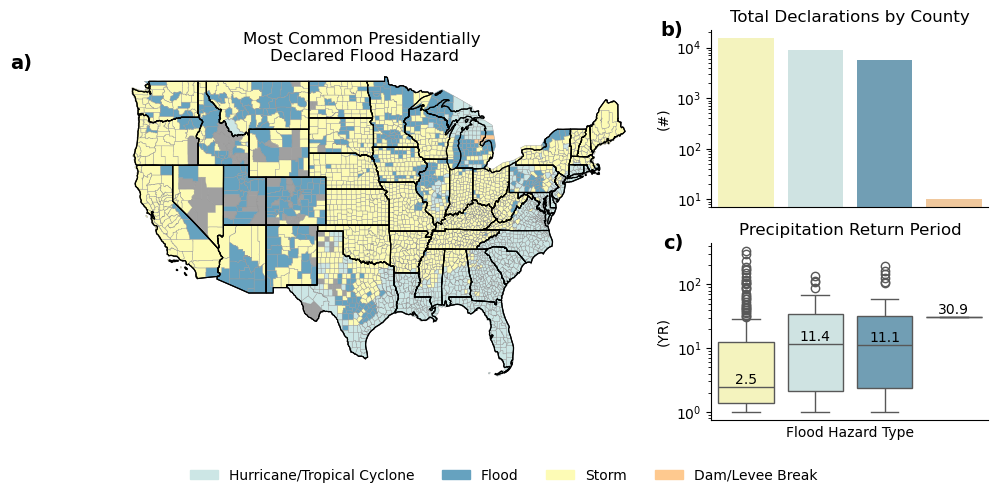

In [7]:
# Adjust figure to have two stacked vertical panels on the right
fig = plt.figure(figsize=(10, 5))  # Adjust size as needed
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])  # Left side for the map, right side for stacked plots
gs_right = gs[1].subgridspec(2, 1, height_ratios=[1, 1])  # Adjust height ratios to make right panels slightly shorter

# 1. Map of mode disaster type by county (left panel)
ax_map = fig.add_subplot(gs[0])
gdf_counties[gdf_counties['incidentType'].isna()].plot(
    ax=ax_map, color='#a0a0a0', edgecolor='0.6', linewidth=0.3
)
gdf_counties[~gdf_counties['incidentType'].isna()].plot(
    column='incidentType', cmap=disaster_cmap, norm=norm, linewidth=0.3,
    ax=ax_map, edgecolor='0.6', categorical=True
)
# Draw state boundaries ABOVE (vectors)
gdf_states.boundary.plot(ax=ax_map, edgecolor='black', linewidth=0.8, zorder=3)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax_map)

ax_map.set_title('Most Common Presidentially \nDeclared Flood Hazard')
ax_map.set_xlim(-130, -65)
ax_map.set_ylim(24, 50)
ax_map.axis('off')
gdf_states.boundary.plot(ax=ax_map, edgecolor='black', linewidth=0.8)
ax_map.text(-0.1, 1.05, 'a)', transform=ax_map.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# Create and center custom legend for disaster types below subplot a
legend_handles = [mpatches.Patch(color=color, label=disaster_type) for disaster_type, color in disaster_colors.items()]
legend = fig.legend(handles=legend_handles, loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.3, 0, 0.4, 0.1))

# 2. Bar plot of disaster counts by type (top right panel)
ax_bar = fig.add_subplot(gs_right[0])
sns.countplot(data=final_disasters_df, x='incidentType', palette=palette, order=incident_order, ax=ax_bar)
rasterize_non_lines(ax_bar)

ax_bar.set_ylabel('(#)')
ax_bar.set_xlabel('')
ax_bar.set_yscale('log')  # Set y-axis to log scale
ax_bar.set_title('Total Declarations by County')
ax_bar.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis labels and ticks
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.text(-0.1, 1.05, 'b)', transform=ax_bar.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 3. Boxplot for maximum returnPeriod_ERA5_30d_max_sum by incident type (bottom right panel)
ax_box = fig.add_subplot(gs_right[1])
sns.boxplot(data=return_period_df, x='incidentType', y=var, 
            palette=palette, order=incident_order, ax=ax_box)
rasterize_non_lines(ax_box)

ax_box.set_yscale('log')
ax_box.set_ylabel('(YR)')
ax_box.set_xlabel('Flood Hazard Type')
ax_box.set_title('Precipitation Return Period')
ax_box.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis labels and ticks
ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.text(-0.1, 1.05, 'c)', transform=ax_box.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# Annotate median values for each incident type
medians = return_period_df.groupby('incidentType')[var].median()
for i, incident_type in enumerate(incident_order):
    median_value = medians[incident_type]
    ax_box.text(i, median_value, f'{median_value:.1f}', ha='center', va='bottom', fontsize=10, color='black')

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Add space at the bottom for the centered legend
if save:
    plt.savefig(
        f'Plots/{folder}Fig_4_Disaster_Types{name}.pdf',
        format='pdf', dpi=500, bbox_inches='tight'
    )
plt.show()